# 노드 13

https://youtu.be/xZKtofBe18I

In [1]:
# !pip install keras-tuner

In [2]:
import tensorflow as tf
import keras
import keras_tuner as kt
from sklearn.model_selection import train_test_split
import os

2024-08-29 14:40:29.760744: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-29 14:40:33.430880: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# MNIST dataset 불러오기
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [4]:
# CNN을 사용할 예정이라 차원 수를 하나 더 추가
X_train = x_train.reshape(-1,28, 28, 1) 
X_test = x_test.reshape(-1,28,28,1)
# label을 categorical을 활용해 변환
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [5]:
# scikit-learn에 내장되어있는 train_test_split 메서드로 훈련,검증데이터 나누기
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(48000, 10)
(12000, 10)


## DeepTuner

DeepTuner의 경우 kerastuner.Tuner를 인자로 하는 class  
class에서 수행하는 함수는 run_trial, save_model load_model입니다.

run_trial 함수에서 제일 중요한 부분은 hypermodel과 trial입니다.

- KerasTuner에서의 hypermodel은 모델을 공유 및 재사용하기 위해 검색 공간을 캡슐화하는 모델입니다. hypermodel의 경우 hp라는 인수를 활용해서 keras.Model을 생성합니다.
즉 hypermodel은 우리가 만들고 싶은 모델을 쌓는 과정을 거치는데 이때 하이퍼파라미터 튜닝에 대한 검색공간을 만들어줄때 hp라는 인수를 사용해서 만든 모델입니다.
hypermodel의 경우 build 메소드를 활용하면 모델이 빌드가 되면서 하이퍼파라미터 튜닝이 시작합니다.

- trial의 경우에는 Oracle에 속하는 class입니다.
Oracle이란 KerasTuner의 모든 검색 알고리즘에서 사용하는 기본 클래스이며 크게 RandomSearchOracle, BayesianOptimizationOracle, HyperbandOracle이 있습니다.
쉽게 설명하면 Oracle은 KerasTuner가 하이퍼파라미터를 정할 때 사용하는 알고리즘이라고 생각하시면 됩니다!
여기서 trial.hyperparameter는 Oracle이 찾아야 하는 하이퍼파라미터입니다. 즉 hypermodel에서의 hp입니다.
제가 model.fit()을 할때 batch_size도 고를 수 있게 만들었습니다.

In [6]:
class DeepTuner(kt.Tuner):
    def run_trial(self, trial, X, y, validation_data, **fit_kwargs):
        model = self.hypermodel.build(trial.hyperparameters)
        model.fit(X, y, batch_size=trial.hyperparameters.Choice(
            'batch_size', [16, 32]), **fit_kwargs)


        X_val, y_val = validation_data
        eval_scores = model.evaluate(X_val, y_val)
        return {name: value for name, value in zip(
            model.metrics_names,
            eval_scores)}

build_model은 위에서 설명한것처럼 hypermodel을 만들어줘야 합니다.  

제가 사용한 첫번째 기법은 바로 layer의 숫자도 KerasTuner에게 맡겼습니다.
for문을 확인해보겠습니다

첫번째 for문의 경우 hp.Int로 만들어 검색공간은 정수로 만들고 가장 작은값을 1로 가장 큰값을 10으로 두었습니다.
이렇게 설정하면 최소 1개에서 최소 10개의 layer를 쌓을 수 있게 설정할 수 있습니다.

제가 쌓고싶은 layer는 conv2D인데 kernel_size는 (3,3)이며 차원수는 최소 32에서 최대 256으로 바꾸었습니다.

두번째 for문을 살펴보겠습니다. 두번째 for문도 최소 1개에서 3개로 설정했지만 Dense Layer의 경우 나올 수 있는 차원을 32,64,128,256중 1개를 선택하도록 만들었습니다.

이러한 방식으로 hypermodel을 만들면 하고싶은 하이퍼 파라미터 튜닝을 진행할 수 있습니다.

In [7]:
def build_model(hp):
    model = tf.keras.Sequential()
    # 해당 모델의 경우 hypermodel이기 때문에 Input지정이 필수, 넣고 싶은 모델에 대한 shape을 꼭 기재
    model.add(tf.keras.Input(shape = X_train.shape[1:], name = 'inputs'))
    # CNN layer수를 keras tuner을 통해 지정(layer수(1~10), unit수(32~128)
    for i in range(hp.Int('num_layers', min_value=1, max_value=10)):
              model.add(tf.keras.layers.Conv2D(hp.Int(
                  'units_{i}'.format(i=i), min_value=32, max_value=128, step=5), (3,3),activation='relu'))
    model.add(tf.keras.layers.Flatten())
    # Dense layer의 노드수를 values중에서 하나 선택
    for i in range(hp.Int('n_connections', 1, 3)):
        model.add(tf.keras.layers.Dense(hp.Choice(f'n_nodes',
                                  values=[32,64,128, 256]), activation = 'relu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax', name = 'outputs'))
    model.compile(optimizer = 'adam',loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [8]:
my_keras_tuner = DeepTuner(
    oracle=kt.oracles.BayesianOptimizationOracle(
        objective=kt.Objective('accuracy', 'max'),
        max_trials=10,
        seed=42),
    hypermodel=build_model,
    overwrite=True,
    project_name='my_keras_tuner')

# 해당 모델 학습시간은 약 10분정도 걸립니다!
my_keras_tuner.search(
    X_train, y_train, validation_data=(X_val, y_val), epochs=3)

Trial 10 Complete [00h 00m 36s]
accuracy: 0.9784166812896729

Best accuracy So Far: 0.9860833287239075
Total elapsed time: 00h 06m 19s


In [10]:
best_hps = my_keras_tuner.get_best_hyperparameters(num_trials=10)[0]
model = build_model(best_hps)
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65 (Conv2D)          (None, 26, 26, 102)       1020      
                                                                 
 conv2d_66 (Conv2D)          (None, 24, 24, 42)        38598     
                                                                 
 conv2d_67 (Conv2D)          (None, 22, 22, 67)        25393     
                                                                 
 conv2d_68 (Conv2D)          (None, 20, 20, 37)        22348     
                                                                 
 conv2d_69 (Conv2D)          (None, 18, 18, 52)        17368     
                                                                 
 flatten_11 (Flatten)        (None, 16848)             0         
                                                                 
 dense_16 (Dense)            (None, 256)             

In [11]:
# 베스트 하이퍼파라미터로 본격 모델학습
model.fit(X_train, y_train, batch_size=32, epochs = 5)

Epoch 1/5
1500/1500 [==============================] - 8s 4ms/step - loss: 0.2910 - accuracy: 0.9541
Epoch 2/5
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0546 - accuracy: 0.9831
Epoch 3/5
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0392 - accuracy: 0.9878
Epoch 4/5
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0315 - accuracy: 0.9900
Epoch 5/5
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0220 - accuracy: 0.9931


In [12]:
# 모델 평가
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0663 - accuracy: 0.9802


[0.06634307652711868, 0.9801999926567078]

**SavedModel**  
h5파일처럼 모델의 가중치와 모델을 전부 하나의 파일로 관리하는 방식이 아닌 모델, 가중치를 따로 구분해서 저장하는 방식입니다.

**구성요소**  
saved_model.pb : pb는 프로토콜 버퍼를 의미하며 해당 파일은 내보낸 모델 그래프 구조를 포함하고 있습니다.
variables : 내보낸 변수값이 있는 이진 파일과 내보낸 모델 그래프에 해당하는 체크포인트를 포함하고 있습니다
assets : 내보낸 모델을 불러올 때 추가적인 파일이 필요한 경우 이 폴더에 파일이 생성됩니다.

In [16]:
save_path = '/home/yoojin/aiffel/exploration_node/7_MLOps/best_model'
fname = os.path.join(save_path, 'model/1')
model.save(fname)

INFO:tensorflow:Assets written to: /home/yoojin/aiffel/exploration_node/7_MLOps/best_model/model/1/assets


INFO:tensorflow:Assets written to: /home/yoojin/aiffel/exploration_node/7_MLOps/best_model/model/1/assets


## 모델 배포

배포를 진행하는 방법은 크게 2가지로 나눌 수 있습니다.

클라우드를 활용해서 모델을 배포하는 방식 -> TFServing 방식   
경량화된 모델을 만들어서 휴대폰같은 디바이스에서도 모델이 실행되게 만드는 방식 -> TFLite방식  

### TFServing

TFServing이란 텐서플로우 그래프를 배포할 수 있으며 표준화된 엔드포인트를 제공합니다.  
또한 모델 및 버전관리가 가능하며 정책 기반으로 모델을 서비스할 수 있습니다.  
또한 지연 시간이 최대한 짧게 만드는 고성능 처리량에서도 초점을 맞추고 있습니다.  

TFServing을 하는 방식은 크게 2가지가 있습니다.  
- Docker를 활용한 배포
- 우분투 터미널을 활용한 배포

실제 디렉토리 : /home/yoojin/aiffel/exploration_node/7_MLOps/best_model/model(아래에 1/pb파일)

#### Docker을 통한 배포

터미널에서  
docker pull tensorflow/serving  

sudo docker run -p 8500:8500 -p 8501:8501 --mount type=bind,source=/home/yoojin/aiffel/exploration_node/7_MLOps/best_model/model,target=/models/my_model -e MODEL_NAME=my_model -e MODEL_BASE_PATH=/models -t tensorflow/serving

해당 명령어의 경우 첫번째 줄은 기본 포트를 지정하는 것이며 2번째줄은 API 포트를 의미합니다. 3번째 줄은 모델 티렉토리를 마운트하는 것입니다. 4번째 줄은 모델 이름을 지정해주고 5번째 줄은 모델의 기본 경로를 의미합니다. 마지막 줄은 tensorflow/serving을 사용한다는 뜻입니다!

<도커 실행상태 확인>  
sudo docker ps   
<도커 종료>  
sudo docker stop **container ID**  

#### TFserving을 통한 배포

우분투에 tensorflow-model-server 설치해서 배포용 텐서플로 서버 구축하기  

echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -  

sudo apt update  

sudo apt install tensorflow-model-server  

터미널에서:   
tensorflow_model_server --port=8500 --rest_api_port=8501 --model_name=my_model --model_base_path=/home/yoojin/aiffel/exploration_node/7_MLOps/best_model/model

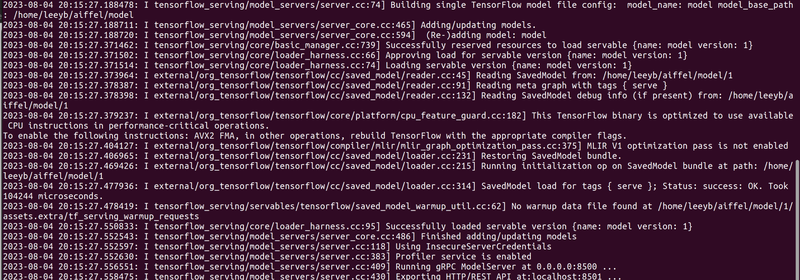  
성공하면 다음과 같은 결과물이 출력됨

##### 서빙된 모델 접근방법  
https://keras.io/examples/keras_recipes/tf_serving/

In [4]:
load_path = '/home/yoojin/aiffel/exploration_node/7_MLOps/best_model/model/1'
best_model = tf.keras.models.load_model(load_path)

2024-08-29 14:40:55.336897: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-29 14:40:56.860549: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-29 14:40:56.861060: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
best_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65 (Conv2D)          (None, 26, 26, 102)       1020      
                                                                 
 conv2d_66 (Conv2D)          (None, 24, 24, 42)        38598     
                                                                 
 conv2d_67 (Conv2D)          (None, 22, 22, 67)        25393     
                                                                 
 conv2d_68 (Conv2D)          (None, 20, 20, 37)        22348     
                                                                 
 conv2d_69 (Conv2D)          (None, 18, 18, 52)        17368     
                                                                 
 flatten_11 (Flatten)        (None, 16848)             0         
                                                                 
 dense_16 (Dense)            (None, 256)             

In [7]:
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpshwaauln/assets


INFO:tensorflow:Assets written to: /tmp/tmpshwaauln/assets
2024-08-29 14:57:02.235909: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-08-29 14:57:02.235952: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-08-29 14:57:02.236791: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpshwaauln
2024-08-29 14:57:02.238536: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-08-29 14:57:02.238560: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpshwaauln
2024-08-29 14:57:02.242845: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-08-29 14:57:02.244241: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-08-29 14:57:02.413837: I tensorflow/cc/saved_model/loader.cc:215] Running initializatio

In [8]:
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [9]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)

signatures = interpreter.get_signature_list()
print(signatures)

{'serving_default': {'inputs': ['inputs'], 'outputs': ['outputs']}}


In [10]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

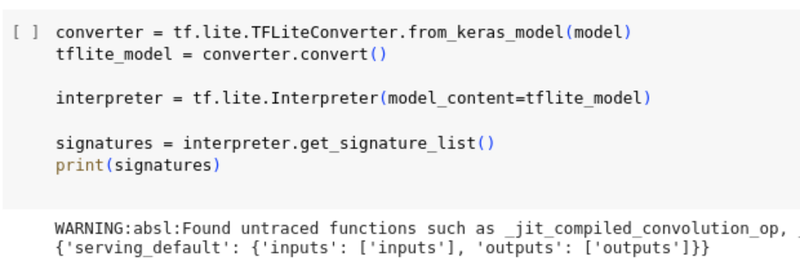  
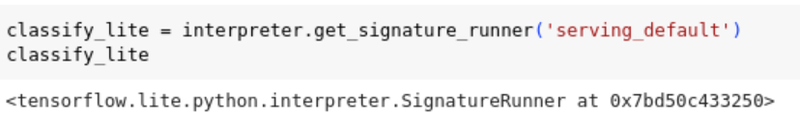  
라고 뜨면 잘 구동된것

# 노드14 : 프로젝트

In [15]:
import tensorflow as tf
import keras
import keras_tuner as kt
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

In [47]:
# MNIST dataset 불러오기
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [48]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


## 데이터 검수하기

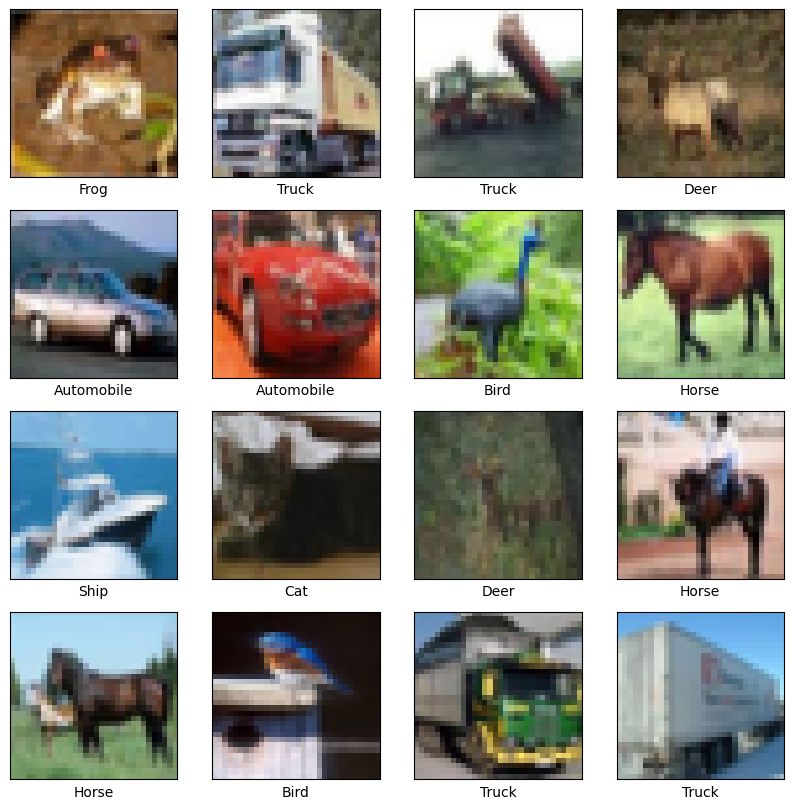

In [49]:
# 클래스 이름 설정 (CIFAR-10은 10개의 클래스가 있습니다)
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# 샘플 이미지 시각화 (예시로 16개 이미지를 그리드 형태로 출력)
def plot_images(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(16):  # 16개의 이미지를 그리드 형태로 출력
        plt.subplot(4, 4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        # 라벨 추가 (0번째 인덱스부터 시작하기 때문에 [0] 필요)
        plt.xlabel(class_names[labels[i][0]])
    plt.show()

# 학습 데이터의 첫 16개 이미지와 라벨 출력
plot_images(x_train, y_train, class_names)

https://labelerrors.com/ 을 통해 잘못된 레이블들 확인하기

In [50]:
wrong_label_image = [2405, 6877, 8058, 2532, 7657, 1969, 2804, 6792, 1227, 5191, 5690, 1718, 2592, 4794, 5960, 165, 9227, 5632, 9352, 7846, 6966, 5468]
print(len(wrong_label_image))

22


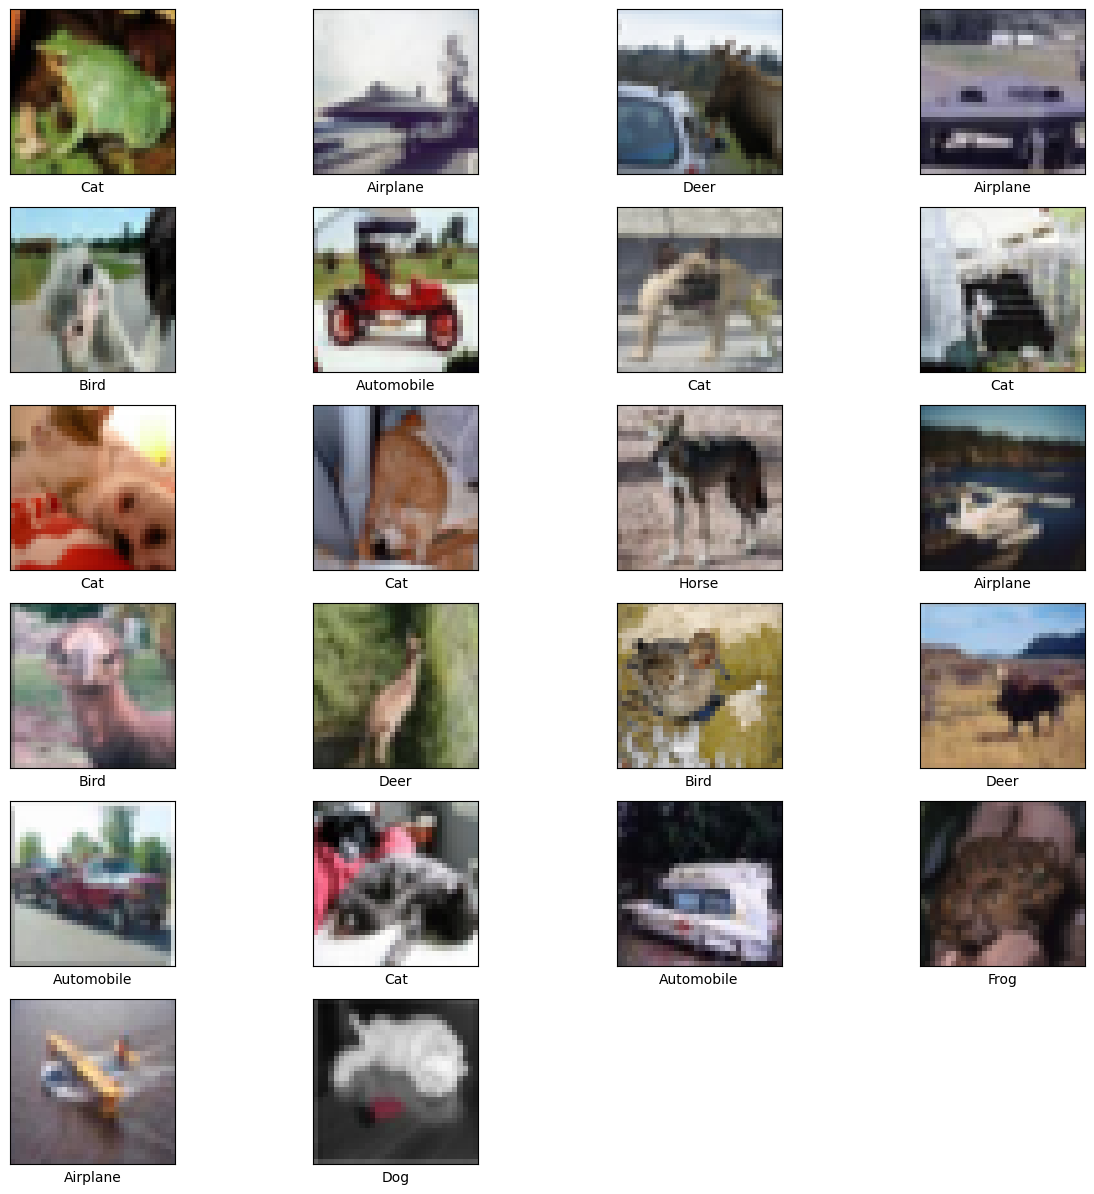

In [51]:
# 클래스 이름 설정 (CIFAR-10은 10개의 클래스가 있습니다)
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# 잘못된 라벨의 이미지를 출력
def plot_wrong_labels(images, labels, indices, class_names):
    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(indices):
        plt.subplot(6, 4, i+1)  # 6x4 그리드에 이미지 출력
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[idx])
        # 라벨 표시 (라벨이 2차원이므로 [0]을 붙임)
        plt.xlabel(class_names[labels[idx][0]])
    plt.show()

# x_test 데이터셋에서 지정된 인덱스의 이미지와 라벨 출력
plot_wrong_labels(x_test, y_test, wrong_label_image, class_names)

In [52]:
# 라벨 수정하기 
correct_label = [6, 8, 7, 1, 7, 9, 5, 9, 5, 5, 4, 8, 4, 2, 3, 2, 9, 5, 9, 3, 8, 3]

for i in range(len(wrong_label_image)):
    index = wrong_label_image[i]
    y_test[index] = correct_label[i]

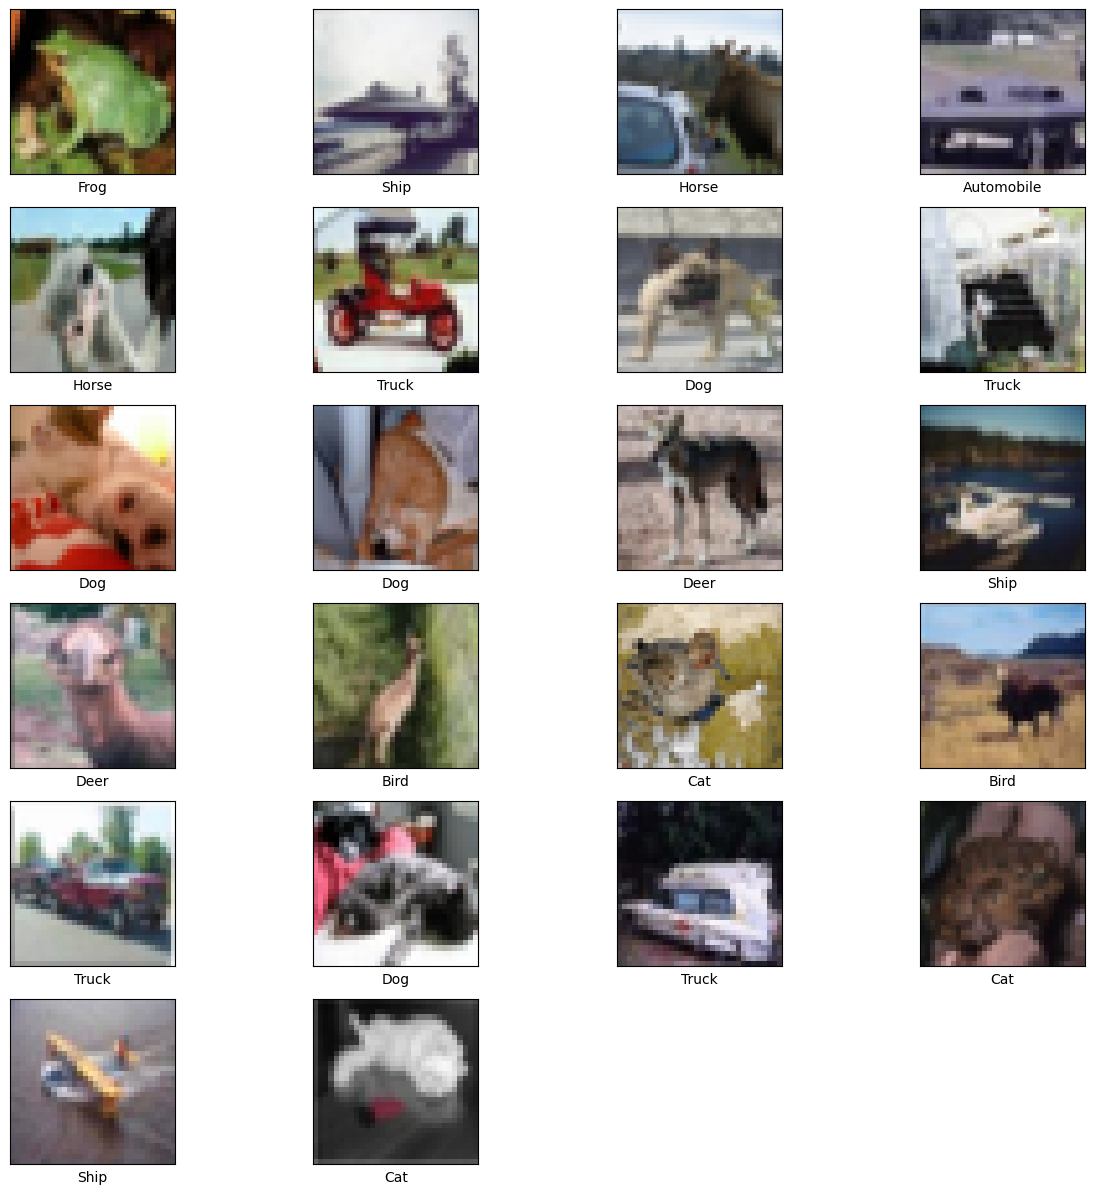

In [53]:
# 수정된 라벨의 이미지를 재출력해서 확인
def plot_wrong_labels(images, labels, indices, class_names):
    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(indices):
        plt.subplot(6, 4, i+1)  # 6x4 그리드에 이미지 출력
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[idx])
        # 라벨 표시 (라벨이 2차원이므로 [0]을 붙임)
        plt.xlabel(class_names[labels[idx][0]])
    plt.show()

# x_test 데이터셋에서 지정된 인덱스의 이미지와 라벨 출력
plot_wrong_labels(x_test, y_test, wrong_label_image, class_names)

In [54]:
# 데이터 정규화
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [55]:
# label을 categorical을 활용해 변환
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [56]:
# scikit-learn에 내장되어있는 train_test_split 메서드로 훈련,검증데이터 나누기
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(40000, 10)
(10000, 10)


### 하이퍼파라미터 튜닝

In [57]:
class DeepTuner(kt.Tuner):
    def run_trial(self, trial, X, y, validation_data, **fit_kwargs):
        model = self.hypermodel.build(trial.hyperparameters)
        model.fit(X, y, batch_size=trial.hyperparameters.Choice(
            'batch_size', [16, 32]), **fit_kwargs)


        X_val, y_val = validation_data
        eval_scores = model.evaluate(X_val, y_val)
        return {name: value for name, value in zip(
            model.metrics_names,
            eval_scores)}

In [63]:
from kerastuner import HyperModel

def build_model(hp):
    model = tf.keras.Sequential()
    
    # 입력 레이어 설정: CIFAR-10 데이터셋에 맞춘 입력 형태 지정
    model.add(tf.keras.Input(shape=(32, 32, 3), name='inputs'))
    
    # CNN 레이어 설정: 케라스 튜너를 사용하여 레이어 수와 유닛 수 튜닝
    for i in range(hp.Int('num_layers', min_value=1, max_value=5)):
        model.add(tf.keras.layers.Conv2D(
            filters=hp.Int(f'units_{i}', min_value=32, max_value=128, step=16), 
            kernel_size=(3, 3),
            activation='relu',
            padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.Flatten())
    
    # Dense 레이어 설정: 노드 수를 튜닝
    for i in range(hp.Int('n_connections', 1, 3)):
        model.add(tf.keras.layers.Dense(
            units=hp.Choice(f'n_nodes_{i}', values=[32, 64, 128, 256]), 
            activation='relu'))
        model.add(tf.keras.layers.Dropout(0.2))
    
    # 출력 레이어 설정: CIFAR-10은 10개의 클래스를 가지므로 유닛 수를 10으로 설정
    model.add(tf.keras.layers.Dense(10, activation='softmax', name='outputs'))
    
    # 모델 컴파일: Adam 옵티마이저와 카테고리 손실 함수 사용
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
my_keras_tuner = DeepTuner(
    oracle=kt.oracles.BayesianOptimizationOracle(
        objective=kt.Objective('accuracy', 'max'),
        max_trials=10,
        seed=42),
    hypermodel=build_model,
    overwrite=True,
    project_name='my_keras_tuner')

# 해당 모델 학습시간은 약 10분정도 걸립니다!
my_keras_tuner.search(
    x_train, y_train, validation_data=(x_val, y_val), epochs=10)

Trial 9 Complete [00h 01m 05s]
accuracy: 0.7469000220298767

Best accuracy So Far: 0.7469000220298767
Total elapsed time: 00h 11m 11s

Search: Running Trial #10

Value             |Best Value So Far |Hyperparameter
3                 |4                 |num_layers
80                |128               |units_0
1                 |2                 |n_connections
64                |32                |n_nodes_0
80                |80                |units_1
80                |32                |units_2
96                |128               |units_3
128               |256               |n_nodes_1
16                |32                |batch_size
48                |32                |units_4
32                |256               |n_nodes_2



In [ ]:
best_hps = my_keras_tuner.get_best_hyperparameters(num_trials=10)[0]
model = build_model(best_hps)
model.summary()

In [11]:
# 베스트 하이퍼파라미터로 본격 모델학습
model.fit(X_train, y_train, batch_size=32, epochs = 5))

Epoch 1/5
1500/1500 [==============================] - 8s 4ms/step - loss: 0.2910 - accuracy: 0.9541
Epoch 2/5
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0546 - accuracy: 0.9831
Epoch 3/5
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0392 - accuracy: 0.9878
Epoch 4/5
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0315 - accuracy: 0.9900
Epoch 5/5
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0220 - accuracy: 0.9931


In [12]:
# 모델 평가
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0663 - accuracy: 0.9802


[0.06634307652711868, 0.9801999926567078]